In [ ]:
!pip install -qU langgraph langchain openai tavily-python langchain_openai langchain_community wikipedia

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'YOUR_OPENAI_API_KEY'
os.environ['TAVILY_API_KEY'] = 'YOUR_TAVILY_API_KEY'

# Web Research (STORM)

**STORM** is a research assistant to extend the idea of "outline-driven RAG" for richer article generation.

STORM is designed to generate Wikipedia-style articles on a user-provided topic. It applies two main insights to produce more organized and comprehensive articles:
1. **Creating an outline** (planning) by querying similar topics helps improve converage.
2. **Multi-perspective**, grounded (in search) conversation simulation helps increase the reference count and information density.

STORM has a few main stages:
1. Generate initial outline + Survey related subjects
2. Identify distinct perspectives
3. "Interview subject matter experts" (role-playing LLMs)
4. Refine outline (using references)
5. Write sections, then write article

The expert interview stage occurs between the role-playing article writer and a research expert. The "expert" is able to query external knowledge and respond to pointed questions, saving cited sources to a vectorstore so that the later refinement stages can synthesize the full article.

# Select LLMs

We need a faster LLM do most of the work, but a slower, long-context model to distill the conversations and write the final report.

In [3]:
from langchain_openai import ChatOpenAI

fast_llm = ChatOpenAI(model='gpt-4o-mini')
long_context_llm = ChatOpenAI(model='gpt-4o')

# Generate Initial Outline

For many topics, our LLMs may have an initial idea of the important and related topics. We can generate an initial outline to be refined after our research. Here, we will use our "fast" LLM to generate the outline.

In [19]:
from typing import List, Optional
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate


direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are a Wikipedia writer. Write an outline for a Wikipedia page about a user-provided topic.'
            ' Be comprehensive and specific.',
        ),
        (
            'user',
            '{topic}',
        )
    ]
)


class SubSection(BaseModel):
    subsection_title: str = Field(
        ...,
        title='Title of the subsection',
    )
    description: str = Field(
        ...,
        title='Content of the subsection',
    )

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.description}".strip()


class Section(BaseModel):
    section_title: str = Field(
        ...,
        title='Title of the section',
    )
    description: str = Field(
        ...,
        title='Content of the section',
    )
    subsections: Optional[List[SubSection]] = Field(
        default=None,
        title='Titles and descriptions of each subsection of the Wikipedia page.',
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            f"### {subsection.subsection_title}\n\n{subsection.description}"
            for subsection in self.subsections or []
        )

        return f"## {self.section_title}\n\n{self.description}\n\n{subsections}".strip()


class Outline(BaseModel):
    page_title: str = Field(
        ...,
        title='Title of the Wikipedia page',
    )
    sections: List[Section] = Field(
        default_factory=list,
        title='Titles and descriptions for each section of the Wikipedia page.',
    )

    @property
    def as_str(self) -> str:
        sections = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()



generate_outline_direct = direct_gen_outline_prompt | fast_llm.with_structured_output(Outline)

In [20]:
# Test
example_topic = "Impact of million-plus token context window language models on RAG"

initial_outline = generate_outline_direct.invoke({'topic': example_topic})

print(initial_outline.as_str)

# Impact of Million-Plus Token Context Window Language Models on RAG

## Introduction

An overview of language models with million-plus token context windows, the concept of Retrieval-Augmented Generation (RAG), and the importance of studying their impact.

## Background

A detailed explanation of language models, context windows, and the evolution towards million-plus token models.

## Retrieval-Augmented Generation (RAG)

Definition of RAG, its components, and the process of combining retrieval and generation in language models.

## Impact of Million-Plus Token Context Windows on RAG

Analysis of how million-plus token context windows enhance RAG performance.

## Advantages of Extended Context Windows

Exploration of the benefits of using longer context windows in RAG, including improved coherence, relevance, and information retention.

## Challenges and Limitations

Discussion of the technical challenges and limitations associated with implementing million-plus token context windows

# Expand Topics

While language models do store some Wikipedia-like knowledge in their parameters, we will get better results by incorporating relevant and recent information using a search engine.

We start our search by generating a list of related topics, sourced from Wikipedia.

In [21]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    """I'm writing a Wikipedia page for a topic mentioned below.
    Please identify and recommend some Wikipedia pages on closely related subjects.
    I'm looking for examples that provide insights into interesting aspects commonly associated with this topic,
    or examples that help me understand the typical content and structure included in Wikipedia pages for similar topics.

    Please list only 3 subjects

    Topic of interest: {topic}
    """
)


class RelatedSubjects(BaseModel):
    topics: List[str] = Field(
        description="Comprehensive list of related subjects as background research.",
    )


expand_chain = gen_related_topics_prompt | fast_llm.with_structured_output(
    RelatedSubjects
)

In [22]:
# test
related_subjects = await expand_chain.ainvoke({'topic': example_topic})

related_subjects

RelatedSubjects(topics=['Token context window', 'Language models', 'Retrieval-Augmented Generation (RAG)'])

# Generate Perspectives

From these related subjects, we can select representative Wikipedia editors as "subject matter experts" with distinct background and affiliations.

These will help distribute the search process to encourage a more well-rounded final report.

In [24]:
class Editor(BaseModel):
    affiliation: str = Field(
        description='Primary affiliation of the editor.',
    )
    name: str = Field(
        description='Name of the editor. Name only contains alphanumeric characters, underscores (_), or hyphens (-), with no spaces or periods.',
        pattern=r"^[a-zA-Z0-9_-]{1,64}$", # only allows alphanumeric characters, _, and - with length between 1 and 64
        #pattern=r"^[a-zA-Z0-9 ._-]{1,64}$",  # Added space and period
    )
    role: str = Field(
        description='Role of the editor in the context of the topic.',
    )
    description: str = Field(
        description="Description of the editor's focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


class Perspectives(BaseModel):
    editors: List[Editor] = Field(
        description="Comprehensive list of editors with their roles and affiliations.",
        # Add a pydantic validation/restriction to be at most M editors
    )

In [25]:
gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            """You need to select a diverse (and distinct) group of Wikipedia editors who will work together to create a comprehensive article on the topic.
            Each of them represents a different perspective, role, or affiliation related to this topic.
            You can use other Wikipedia pages of related topics for inspiration.
            For each editor, add a description of what they will focus on.

            Wiki page outlines of related topics for inspiration:
            {examples}
            """,
        ),
        (
            'user',
            'Topic of interest: {topic}',
        )
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | fast_llm.with_structured_output(Perspectives)

In [26]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables import chain as as_runnable


wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True,
                                         top_k_results=1)


def format_doc(doc, max_length=1000):
    related = "- ".join(doc.metadata['categories'])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[: max_length]

def format_docs(docs):
    return "\n\n".join(format_doc(doc) for doc in docs)

In [27]:
@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({'topic': topic})
    retrieved_docs = await wikipedia_retriever.abatch(
        related_subjects.topics,
        return_exceptions=True,
    )

    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)

    formatted = format_docs(all_docs)

    return await gen_perspectives_chain.ainvoke({'examples': formatted, 'topic': topic})

In [28]:
perspectives = await survey_subjects.ainvoke(example_topic)

In [29]:
perspectives.model_dump()

{'editors': [{'affiliation': 'AI Research Lab',
   'name': 'DrAliceSmith',
   'role': 'AI Researcher',
   'description': 'Dr. Alice Smith will focus on the theoretical implications of million-plus token context windows for large language models, particularly how they enhance the performance of retrieval-augmented generation (RAG) systems. She will provide insights into the architecture changes required and how these models can process and utilize extensive context effectively.'},
  {'affiliation': 'Tech Industry',
   'name': 'JohnDoe123',
   'role': 'Software Engineer',
   'description': 'John Doe, a software engineer at a leading tech company, will discuss practical applications of million-plus token context windows in RAG implementations. He will share case studies from industry projects that utilize these models to improve information retrieval and generation, illustrating the real-world benefits and challenges faced.'},
  {'affiliation': 'Linguistics Department, University',
   'na

# Expert Dialog

Each wikipedia writer is primed to role-play using the perspectives presented above. It will ask a series of questions of a second "domain expert" with access to a search engine. This generate content to generate a refined outline as well as an updated index of reference documents.

## Interview State

The conversation is cyclic, so we will construct it within its own graph.


The State will contain messages, the reference docs, and the editor (with its own "persona") to make it easy to parallelize these conversations.

In [31]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_core.messages import AnyMessage
from langgraph.graph import START, END, StateGraph

def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]

    return left + right


def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references


def update_editor(editor, new_editor):
    # can only set at the outset
    if not editor:
        return new_editor
    return editor



class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

## Dialog Roles

The graph will have two participants: the wikipedia editor (`generate_question`), who asks questions based on its assigned role, and a domain expert (`gen_answer_chain`), who uses a search engine to answer the questions as accurately as possible.

In [32]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langchain_core.prompts import MessagesPlaceholder

gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            """You are an experienced Wikipedia writer and want to edit a specific page.
            Besides your identity as a Wikipedia writer, you have a specific focus when researching the topic.
            Now, you are chatting with an expert to get information. Ask good questions to get more useful information.

            When you have no more questions to ask, say "Thank you so much for your help!" to end the conversation.
            Please only ask one question at a time and don't ask what you have asked before.
            Your questions should be related to the topic you want to write.
            Be comprehensive and curious, gaining as much unique insight from the expert as possible.

            Stay true to your specific perspective:
            {persona}
            """,
        ),
        MessagesPlaceholder(variable_name='messages', optional=True),
    ]
)


def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message


def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state['messages']:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.model_dump(exclude={'type'}))

        converted.append(message)
    return {'messages': converted}


@as_runnable
async def generate_question(state: InterviewState):
    editor = state['editor']

    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | fast_llm
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )

    result = await gn_chain.ainvoke(state)
    return {'messages': [result]}

In [33]:
messages = [
    HumanMessage(f"So you said you were writing an article on {example_topic}?")
]

question = await generate_question.ainvoke(
    {
        'editor': perspectives.editors[0],
        'messages': messages,
    }
)

question['messages'][0].content

"Yes, that's correct! I'm particularly interested in how the implementation of million-plus token context windows can enhance the performance of retrieval-augmented generation systems. What are some specific architectural changes that you believe are necessary to support such extensive context processing in large language models?"

## Answer questions

The `gen_answer_chain` first generates queries (query expansion) to answer the editor's question, then responds with citations.

In [34]:
class Queries(BaseModel):
    queries: List[str] = Field(
        description="Comprehensive list of search engine queries to answer the user's questions."
    )


gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            "You are a helpful research assistant. Query the search engine to answer the user's questions.",
        ),
        MessagesPlaceholder(variable_name='messages', optional=True),
    ]
)


gen_queries_chain = gen_queries_prompt | fast_llm.with_structured_output(Queries, include_raw=True)

In [35]:
# test
queries = await gen_queries_chain.ainvoke(
    {'messages': [HumanMessage(content=question['messages'][0].content)]}
)

queries['parsed'].queries

['million-plus token context windows in language models',
 'architectural changes for large context windows in language models',
 'retrieval-augmented generation systems with large context',
 'impact of long context on language model performance',
 'enhancing retrieval-augmented generation with extensive context processing',
 'large language models architecture for handling million tokens']

In [36]:
class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="Comprehensive answer to the user's question with citations."
    )
    cited_urls: List[str] = Field(
        description="List of urls cited in the answer."
    )

    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\nCitations:\n\n" + "\n".join(
            f"[{i+1}]: {url}" for i,url in enumerate(self.cited_urls)
        )


gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            """You are an expert who can use information effectively.
            You are chatting with a Wikipedia writer who wants to write a Wikipedia page on the topic you know.
            You have gathered the related information and willl now use the information to form a response.

            Make your response as informative as possible and make sure every sentence is supported by the gathered information.
            Each response must be backed up by a citation from a reliable source, formatted as a footnote, reproducing the URLs after your response.
            """
        ),
        MessagesPlaceholder(variable_name='messages', optional=True)
    ]
)


gen_answer_chain = gen_answer_prompt | fast_llm.with_structured_output(AnswerWithCitations, include_raw=True).with_config(run_name='Generate Answer')

In [37]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

search = TavilySearchAPIWrapper()
tavily_search = TavilySearchResults(api_wrapper=search, max_results=4)

@tool
async def search_engine(query: str):
    """Search engine to the internet"""
    results = tavily_search.invoke(query)
    return [{'content': r['content'], 'url': r['url']} for r in results]

In [48]:
! pip install -qU duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.5 MB/s eta 0:00:00


In [49]:
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper

search_engine = DuckDuckGoSearchAPIWrapper()

def search_engine(query: str):
    """Search engine to the internet"""
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
    return results

In [51]:
search_engine("best product on amazon.com")

[{'title': 'The Absolute Best Products Available on Amazon Right Now',
  'href': 'https://katiecouric.com/lifestyle/best-amazon-products-to-buy-right-now/',
  'body': "The 28 top deals, hidden gems, and best-reviewed items on Amazon, some of which are are sale right now during Amazon Prime Day. From Apple AirPods to TikTok's favorite backpack, here's what's worth hunting for this Prime Day. ... the Katie Couric Media staff scoured the mega retailer's offerings to compile a list of must-have products ..."},
 {'title': '20 Things On Amazon That Make Perfect Gifts - HuffPost',
  'href': 'https://www.huffpost.com/entry/best-gifts-amazon_l_67565020e4b0015618de03bf',
  'body': 'Hands down, the best product for the money." — Natalie. $46 at Amazon. Advertisement. 7. amazon.com. A tabletop fire pit. Promising review: "Love this fun little table top firepit. Just what we needed when we don\'t feel like lighting a fire for s\'mores!" ... — Amazon Customer. $16.99 at Amazon. 11. amazon.com. A pac

In [38]:
import json

from langchain_core.runnables import RunnableConfig


async def gen_answer(
    state: InterviewState,
    config: Optional[RunnableConfig] = None,
    name: str = "Subject_Matter_Expert",
    max_str_len: int = 15000,
):
    # Convert all other AI messages
    swapped_state = swap_roles(state, name)

    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_results = await search_engine.abatch(
        queries['parsed'].queries,
        config,
        return_exceptions=True,
    )
    successful_results = [
        res for res in query_results if not isinstance(res, Exception)
    ]
    all_query_results = {
        res['url']: res['content'] for results in successful_results for res in results
    }

    # We could be more precise about handling max token length if we want to
    dumped = json.dumps(all_query_results)[:max_str_len]
    ai_message: AIMessage = queries['raw']
    tool_call = queries['raw'].tool_calls[0]
    tool_id = tool_call['id']
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)

    swapped_state['messages'].extend([ai_message, tool_message])

    # Only update the shared state with the final answer to avoid polluting the dialogue history
    # with intermediate messages
    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated['parsed'].cited_urls)

    # Save the retrieved information to a shared state for future reference
    cited_references = {
        k: v for k, v in all_query_results.items() if k in cited_urls
    }
    formatted_message = AIMessage(name=name, content=generated['parsed'].as_str)

    return {'messages': [formatted_message], 'references': cited_references}

In [39]:
example_answer = await gen_answer(
    {'messages': [HumanMessage(content=question['messages'][0].content)]}
)

example_answer['messages'][-1].content

"The implementation of million-plus token context windows in retrieval-augmented generation (RAG) systems can significantly enhance their performance by allowing these models to utilize and process a much larger amount of information in a single pass. This capability can improve the relevance and accuracy of generated responses, particularly in complex tasks requiring extensive information synthesis. To support such extensive context processing, several architectural changes are necessary:\n\n1. **Memory Augmentation**: Incorporating external memory architectures can help models manage and retrieve vast quantities of information more effectively. Techniques such as memory-augmented neural networks or differentiable neural computers can be integrated to facilitate the storage and retrieval of long-term context information, enabling the model to access and utilize more than just the immediate input context.\n\n2. **Sparse Attention Mechanisms**: Traditional attention mechanisms can becom

## Construct the interview Graph

Now that we have defined the editor and domain expert, we can compose them in a graph.

In [40]:
from langgraph.pregel import RetryPolicy

max_num_turns = 5


def route_messages(state: InterviewState, name: str = "Subject_Matter_Expert"):
    messages = state['messages']
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    if num_responses >= max_num_turns:
        print("Reached max number of turns")
        return END

    last_question = messages[-2]
    if last_question.content.endswith("Thank you so much for your help!"):
        return END

    return "ask_question"

In [41]:
builder = StateGraph(InterviewState)

# Add nodes
builder.add_node('ask_question', generate_question, retry=RetryPolicy(max_attempts=3))
builder.add_node('answer_question', gen_answer, retry=RetryPolicy(max_attempts=3))
# Add edges
builder.add_edge(START, 'ask_question')
builder.add_edge('ask_question', 'answer_question')
builder.add_conditional_edges('answer_question', route_messages)


interview_graph = builder.compile(checkpointer=False).with_config(
    run_name="Conduct Interviews"
)

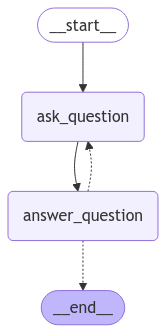

In [42]:
from IPython.display import Image, display

display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [43]:
final_step = None

initial_state = {
    'editor': perspectives.editors[0],
    'messages': [
        AIMessage(
            content=f"So you said you were writing an article on {example_topic}",
            name="Subject_Matter_Expert",
        )
    ]
}

initial_state

{'editor': Editor(affiliation='AI Research Lab', name='DrAliceSmith', role='AI Researcher', description='Dr. Alice Smith will focus on the theoretical implications of million-plus token context windows for large language models, particularly how they enhance the performance of retrieval-augmented generation (RAG) systems. She will provide insights into the architecture changes required and how these models can process and utilize extensive context effectively.'),
 'messages': [AIMessage(content='So you said you were writing an article on Impact of million-plus token context window language models on RAG', additional_kwargs={}, response_metadata={}, name='Subject_Matter_Expert')]}

In [44]:
async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name]['messages'])[:300])

final_step = step

ask_question
--  [AIMessage(content="Yes, I'm focusing on the theoretical implications of million-plus token context windows for large language models, particularly in the context of retrieval-augmented generation (RAG) systems. Could you explain how the ability to process such extensive context could fundamentally 
answer_question
--  [AIMessage(content='The advent of million-plus token context windows in large language models (LLMs) represents a transformative shift in the capabilities of retrieval-augmented generation (RAG) systems. Primarily, such extensive context windows allow these models to retain and process significantly
ask_question
--  [AIMessage(content='DrAliceSmith: Thank you for that insightful explanation! How do you envision the architectural changes that might be necessary to support the implementation of million-plus token context windows in large language models, especially in the context of RAG systems?', additional_kwar
answer_question
--  [AIMessage(content="To 

In [45]:
final_state = next(iter(final_step.values()))
final_state

{'messages': [AIMessage(content="You're welcome! I'm glad I could assist you with your research. If you have any more questions or need further information in the future, feel free to reach out. Good luck with your Wikipedia page on the impact of million-plus token context windows in language models!\n\nCitations:\n\n", additional_kwargs={}, response_metadata={}, name='Subject_Matter_Expert')],
 'references': {}}

# Refine Outline

At this point in STORM, we have conducted a large amount of research from different perspecties. It is time to refine the original outline based on these investigations.

Below, crate a chain using the LLM with a long context window to update the orignal outline.

In [ ]:
refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            """You are a Wikipedia writer. You have gathered information from experts and search engines.
            Now, you are refining the outline of the Wikipedia pages.
            You need to make sure that the outline is comprehensive and specific.
            Topic you are writing about: {topic}

            Old outline:

            {old_outline}
            """,
        ),
        (
            'user',
            """Refine the outline based on your conversation with subject-matter experts:\n\n
            Conversations:\n\n{conversations}\n\n
            Write the refined Wikipedia outline:,
            """
        ),
    ]
)

refine_outline_chain = refine_outline_prompt | long_context_llm.with_structured_output(Outline)

In [ ]:
refined_outline = refine_outline_chain.invoke(
    {
        'topic': example_topic,
        'old_outline': initial_outline.as_str,
        'conversations': "\n\n".join(
            f"### {m.name}\n\n{m.content}" for m in final_state['messages']
        ),
    }
)

In [ ]:
print(refined_outline.as_str)

# Impact of Million-Plus Token Context Window Language Models on RAG

## Introduction

An overview of language models, context windows, and the significance of Retrieval-Augmented Generation (RAG) in natural language processing, with a focus on advancements in context window size.

## Understanding Context Windows

A detailed explanation of context windows within the framework of language models, including the transition from small to million-plus token context windows.

### Evolution of Context Windows

Tracing the development and expansion of context windows from small to extensive million-plus token capabilities.

## Retrieval-Augmented Generation (RAG)

Definition and explanation of RAG, including its components, operational mechanics, and its role in enhancing language model outputs.

### Components of RAG

An overview of the key components of RAG systems and how they function together.

### Significance in NLP

The importance of RAG in natural language processing applications and

# Generate Article

Now it's time to generate the full article. We will first divide-and-conquer, so that each section can be tackled by an individual LLM. Then we will prompt the long-term LLLM to refine the finished article (since each section may use an inconsistent voice).

## Create Retriever

The research process uncovers a large number of reference documents that we may want to query during the final article-writing process.

So we need to create a retriever:

In [ ]:
from langchain_community.vectorstores import InMemoryVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-small')
reference_docs = [
    Document(page_content=v, metadata={'source': k})
    for k, v in final_state['references'].items()
]

# This really does NOT need to be a vector store for this size of data.
vectorstore = InMemoryVectorStore.from_documents(
    reference_docs,
    embedding=embeddings,
)
retriever = vectorstore.as_retriever(k=3)

In [ ]:
retriever.invoke("What is a long context LLM?")

[Document(id='cb2e27ef-857a-40dd-97be-f011d6f945ac', metadata={'source': 'https://github.com/Xnhyacinth/Awesome-LLM-Long-Context-Modeling'}, page_content='Retrieval Augmented Generation (RAG) and Beyond: A Comprehensive Survey on How to Make your LLMs use External Data More Wisely. ... LongRoPE: Extending LLM ContextWindow Beyond 2 Million Tokens. Yiran Ding, Li Lyna Zhang, Chengruidong Zhang, Yuanyuan Xu, Ning Shang, Jiahang Xu, Fan Yang, Mao Yang. ... EasyAnimate: A High-Performance Long Video'),
 Document(id='3aed1356-cc96-4322-8172-899531e89524', metadata={'source': 'https://thesalt.substack.com/p/rag-and-long-context-llms-when-do'}, page_content='The study includes a large-scale evaluation of 50 RAG systems and 10 long-context LLMs. Key findings are: (1) SummHay is challenging for all systems, with performance below human levels, (2) trade-offs exist between RAG pipelines and long-context LLMs, with RAG improving citation quality but compromising insight coverage, (3) advanced RAG

## Generate Sections

Next we can generate the sections using the indexed documents.

In [ ]:
class SubSection(BaseModel):
    subsection_title: str = Field(
        ...,
        title='Title of the subsection'
    )
    content: str = Field(
        ...,
        title='Fulll content of the subsection. Include [#] citations to the cited sources where rellevant.'
    )

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.content}".strip()


class WikiSection(BaseModel):
    section_title: str = Field(
        ...,
        title="Title of the section"
    )
    content: str = Field(
        ...,
        title="Full content of the section"
    )
    subsections: Optional[List[SubSection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )
    citations: List[str] = Field(
        default_factory=list
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            subsection.as_str for subsection in self.subsections or []
        )
        citations = "\n".join(
            [f" [{i}] {cit}" for i, cit in enumerate(self.citations)]
        )

        return (
            f"## {self.section_title}\n\n{self.content}\n\n{subsections}".strip()
            + f"\n\n{citations}".strip()
        )

In [ ]:
section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            """You are an expert Wikipedia writer. Complete your assigned WikiSection from the following outlline\n\n:
            {outline}\n\nCite your sources, using the following references:\n\n<Documents>\n{docs}\n</Documents>
            """
        ),
        (
            'user',
            "Write the full WikiSection for the {section} section."
        )
    ]
)


async def retrieve(inputs: dict):
    docs = await retriever.ainvoke(inputs['topic'] + ": " + inputs['section'])
    formatted = "\n".join(
        [
            f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )
    return {'docs': formatted, **inputs}


section_writer = (
    retrieve
    | section_writer_prompt
    | long_context_llm.with_structured_output(WikiSection)
)

In [ ]:
section = await section_writer.ainvoke(
    {
        'outline': refined_outline.as_str,
        'section': refined_outline.sections[1].section_title,
        'topic': example_topic,
    }
)

In [ ]:
print(section.as_str)

## Understanding Context Windows

Context windows are a foundational concept in language models, representing the span of text data that a model can consider at one time. They dictate the amount of preceding context a language model can use when generating text, which directly influences the coherence and relevance of its outputs. Traditional language models have operated with relatively limited context windows, often constrained to a few hundred tokens. However, recent advancements have seen the expansion of context windows to encompass millions of tokens, dramatically changing how these models process and generate language.

### Evolution of Context Windows

The evolution of context windows in language models has been marked by a steady increase in size, driven by the need for more coherent and contextually aware outputs. Initially, language models like GPT-2 and BERT utilized context windows limited to 512 tokens. This limitation posed significant challenges, especially in tasks req

## Generate Final Article

Now we can rewrite the draft to appropriately group all the citations and maintaiin a consistent voicce.

In [ ]:
from langchain_core.output_parsers import StrOutputParser

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            """You are an expert Wikipedia author. Write the complete wiki article on {topic} using the following section drafts:\n\n
            {draft}\n\nStrictlly follow Wikipedia format guidelines.
            """
        ),
        (
            'user',
            """Write the complete Wiki article using markdown format. Organize citations using footnotes like "[1]",
            avoiding duplicates in the footer. Include URLs in the footer.
            """
        )
    ]
)

writer = writer_prompt | long_context_llm | StrOutputParser()

In [ ]:
for tok in writer.stream(
    {
        'topic': example_topic,
        'draft': section.as_str,
    }
):
    print(tok, end="")

# Impact of Million-Plus Token Context Window Language Models on Retrieval-Augmented Generation (RAG)

## Introduction

In recent years, the field of natural language processing (NLP) has witnessed significant advancements, particularly in the development of language models with extended context windows. These advancements have profound implications for various applications, including Retrieval-Augmented Generation (RAG), where the ability to process and generate language with extensive context is crucial for improving the quality and relevance of outputs. This article explores the impact of million-plus token context window language models on RAG, highlighting the evolution of context windows and their significance in modern NLP applications.

## Understanding Context Windows

Context windows are a foundational concept in language models, representing the span of text data that a model can consider at one time. They dictate the amount of preceding context a language model can use when

# Final Flow

Now we can string everything together. We will have 6 main stages in sequences:
1. Generate the initial outline + perspectives
2. Batch converse with each perspective to expand the content for the article
3. Refine the outline based on the cconversations
4. Index the reference docs from the conversations
5. Write the indiviidual sections of the article
6. Write the final Wikipage.

We will also have the state to track the outputs of each stage:

In [233]:
class MainState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]
    # The final sections output
    sections: List[WikiSection]
    article: str

In [234]:
import asyncio

async def initialize_research(state: MainState):
    topic = state['topic']
    coros = (
        generate_outline_direct.ainvoke({'topic': topic}), # -> outline
        survey_subjects.ainvoke(topic), # -> perspectives
    )
    results = await asyncio.gather(*coros)

    return {
        **state,
        'outline': results[0],
        'editors': results[1].editors,
    }


async def conduct_interviews(state: MainState):
    topic = state['topic']
    initial_states = [
        {
            'editor': editor,
            'messages': [
                AIMessage(
                    content=f"So you said you were writing an article on {topic}?",
                    name="Subject_Matter_Expert",
                )
            ],
        }
        for editor in state['editors']
    ]

    # We call in to the sub-graph here to parallelize the interviews
    interview_results = await interview_graph.abatch(initial_states)

    return {
        **state,
        'interview_results': interview_results,
    }


def format_conversation(interview_state):
    messages = interview_state['messages']

    convo = "\n".join(f"{m.name}: {m.content}" for m in messages)
    return f"Conversation with {interview_state['editor'].name}\n\n" + convo


async def refine_outline(state: MainState):
    convos = "\n\n".join(
        [
            format_conversation(interview_state)
            for interview_state in state['interview_results']
        ]
    )

    updated_outline = await refine_outline_chain.ainvoke(
        {
            'topic': state['topic'],
            'old_outline': state['outline'].as_str,
            'conversations': convos,
        }
    )

    return {**state, 'outline': updated_outline}


async def index_references(state: MainState):
    all_docs = []
    for interview_state in state['interview_results']:
        reference_docs = [
            Document(page_content=v, metadata={'source': k})
            for k,v in interview_state['references'].items()
        ]
        all_docs.extend(reference_docs)

    await vectorstore.aadd_documents(all_docs)
    return state


async def write_sections(state: MainState):
    outline = state['outline']
    sections = await section_writer.abatch(
        [
            {
                'outline': outline.as_str,
                'section': section.section_title,
                'topic': state['topic'],
            }
            for section in outline.sections
        ]
    )

    return {**state, 'sections': sections}


async def write_acticle(state: MainState):
    topic = state['topic']
    sections = state['sections']
    draft = "\n\n".join([section.as_str for section in sections])
    article = await writer.ainvoke(
        {
            'topic': topic,
            'draft': draft,
        }
    )

    return {**state, 'article': article}

## Create the Graph

In [235]:
from langgraph.checkpoint.memory import MemorySaver

builder_of_storm = StateGraph(MainState)

nodes = [
    ('init_research', initialize_research),
    ('conduct_interviews', conduct_interviews),
    ('refine_outline', refine_outline),
    ('index_references', index_references),
    ('write_sections', write_sections),
    ('write_acticle', write_acticle),
]


for i in range(len(nodes)):
    name, node = nodes[i]
    builder_of_storm.add_node(name, node, retry=RetryPolicy(max_attempts=3))
    if i > 0:
        builder_of_storm.add_edge(nodes[i-1][0], name)

builder_of_storm.add_edge(START, nodes[0][0])
builder_of_storm.add_edge(nodes[-1][0], END)

storm = builder_of_storm.compile(checkpointer=MemorySaver())

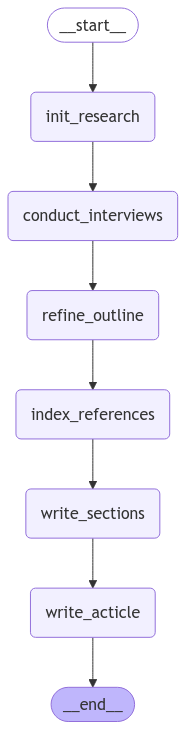

In [236]:
from IPython.display import Image, display

display(Image(storm.get_graph().draw_mermaid_png()))

In [237]:
config = {'configurable': {'thread_id': 'storm-thread-001'}}

async for step in storm.astream(
    {
        'topic': "Steph Curry, One-motion shooting, and Modern Basketball",
    },
    config,
):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name])[:300])

init_research
--  {'topic': 'Steph Curry, One-motion shooting, and Modern Basketball', 'outline': Outline(page_title='Steph Curry, One-motion shooting, and Modern Basketball', sections=[Section(section_title='Introduction', description='An overview of the significance of Steph Curry in modern basketball, focusing on 


/usr/lib/python3.10/inspect.py:2412: RuntimeWarning: coroutine 'RunnableLambda.ainvoke' was never awaited
  obj = unwrap(obj, stop=(lambda f: hasattr(f, "__signature__")
/usr/lib/python3.10/inspect.py:2412: RuntimeWarning: coroutine 'RunnableSequence.ainvoke' was never awaited
  obj = unwrap(obj, stop=(lambda f: hasattr(f, "__signature__")


Reached max number of turns
Reached max number of turns
Reached max number of turns
Reached max number of turns
Reached max number of turns
Reached max number of turns
conduct_interviews
--  {'topic': 'Steph Curry, One-motion shooting, and Modern Basketball', 'outline': Outline(page_title='Steph Curry, One-motion shooting, and Modern Basketball', sections=[Section(section_title='Introduction', description='An overview of the significance of Steph Curry in modern basketball, focusing on 
refine_outline
--  {'topic': 'Steph Curry, One-motion shooting, and Modern Basketball', 'outline': Outline(page_title='Steph Curry, One-motion Shooting, and Modern Basketball', sections=[Section(section_title='Introduction', description='An overview of the significance of Steph Curry in modern basketball, focusing on 
index_references
--  {'topic': 'Steph Curry, One-motion shooting, and Modern Basketball', 'outline': Outline(page_title='Steph Curry, One-motion Shooting, and Modern Basketball', sections=

In [238]:
checkpoint = storm.get_state(config)
article = checkpoint.values['article']

# Render the Article

In [240]:
from IPython.display import Markdown

# We will down-header the sections to create less confusion in this notebook
#Markdown(article.replace("\n#", "\n##"))

Markdown(article)

# Steph Curry, One-motion Shooting, and Modern Basketball

## Introduction

Stephen Curry, often regarded as one of the greatest shooters in basketball history, has significantly influenced the modern game with his unique shooting style and exceptional skill set. His rise to prominence in the National Basketball Association (NBA) has not only redefined offensive strategies but has also shifted the perception of what is possible in the sport. Central to Curry's success is his mastery of the one-motion shooting technique, which combines fluidity and efficiency, allowing him to shoot with precision from virtually any distance on the court. This technique has set a new standard for shooting in basketball, inspiring players at all levels to emulate his approach.

Curry's impact extends beyond his individual achievements; he has revolutionized how teams approach the game. His influence is evident in the increasing emphasis on three-point shooting and the development of players who prioritize shooting accuracy and range. As teams adapt to this new style of play, defensive strategies have also evolved to contain the threat posed by prolific shooters like Curry.

Moreover, Curry's influence transcends the basketball court, affecting cultural and social aspects of the game. His success has inspired a generation of young players, and his involvement in community and social initiatives has further solidified his status as a role model. As the game continues to evolve, Stephen Curry's contributions to basketball will remain pivotal in shaping its future. By examining his career and the rise of one-motion shooting, we gain insight into the transformative power of innovation in sports and its lasting impact on both players and fans worldwide.[1]

## Steph Curry: A Brief Biography

Stephen Curry, widely known as "Steph," was born on March 14, 1988, in Akron, Ohio. He is the son of former NBA player Dell Curry and Sonya Curry, a former volleyball player at Virginia Tech. Raised in Charlotte, North Carolina, Steph was introduced to basketball at a young age and honed his skills under the guidance of his father.

Curry attended Charlotte Christian School, where he quickly became a standout player, earning all-state honors and leading his team to three conference titles. Despite his high school success, Curry was considered too small and not heavily recruited by major college basketball programs. He eventually accepted a scholarship offer from Davidson College, a small liberal arts college in North Carolina.

At Davidson, Curry made an immediate impact, leading the Wildcats to the NCAA Tournament in his freshman year. His breakout moment came during the 2008 NCAA Tournament, where he led Davidson to the Elite Eight, defeating powerhouses such as Gonzaga and Georgetown. Curry's exceptional shooting and scoring abilities gained him national attention, and he finished his college career as Davidson's all-time leading scorer.

In 2009, Curry declared for the NBA Draft and was selected seventh overall by the Golden State Warriors. Over the years, he has developed into one of the most iconic players in NBA history. Known for his exceptional shooting ability, particularly from long distance, Curry has transformed the game of basketball, becoming a two-time NBA MVP and leading the Warriors to multiple NBA championships. His influence extends beyond the court, inspiring countless young players to emulate his playing style and work ethic.

## One-motion Shooting Technique

The one-motion shooting technique, as exemplified by Steph Curry, is a revolutionary approach in basketball shooting that emphasizes fluidity, efficiency, and range. This technique diverges from traditional shooting forms by integrating the entire body in a seamless motion, allowing players to achieve greater power and accuracy with less perceived effort.

### Definition and Characteristics

One-motion shooting is characterized by a continuous and fluid movement where the shooter's feet, hips, shoulders, and elbow work in harmony to produce a single, uninterrupted shot. Unlike the traditional two-motion shot, which involves a pause at the set point before the release, the one-motion shot eliminates this pause, resulting in a smoother and quicker release. This fluidity is key to generating power and range, as the energy flows from the lower body through the core and into the shooting hand in a cohesive manner. Steph Curry's shooting mechanics are a prime example of this technique, which has contributed significantly to his success as one of the greatest shooters in NBA history.[2][3]

### Historical Context

The evolution of shooting techniques in basketball has seen a gradual shift from set shots and two-motion shooting to more dynamic and efficient methods like the one-motion shot. Early basketball focused heavily on set shots, which were later supplemented by the two-motion jump shot as players sought more versatility and effectiveness. The introduction of the one-motion shot marks a significant advancement, combining elements of both previous techniques but streamlining them to maximize speed and efficiency. This evolution reflects broader changes in the game, where speed and adaptability have become crucial.[3]

### Comparison with Other Shooting Techniques

One-motion shooting stands in contrast to other prevalent techniques such as two-motion shooting and set shots. The two-motion shot involves a distinct pause between the jump and the release, allowing for additional calibration but often resulting in a slower release. Set shots, while stable, lack the dynamism needed in modern fast-paced games. The one-motion shot, by merging these phases into one fluid action, offers a quicker release, reducing the time defenders have to contest the shot. This makes it particularly valuable in the current basketball landscape, where speed and precision are essential.[2][3][1]

## Steph Curry's Influence on One-motion Shooting

Stephen Curry's influence on the one-motion shooting technique cannot be overstated. His ability to consistently deliver high-percentage shots from beyond the three-point line has not only redefined individual performance metrics but also revolutionized team strategies across the NBA. Curry's shooting style, characterized by its fluidity and efficiency, has become a benchmark for aspiring shooters around the world. As Curry rose to prominence, his success with the one-motion shooting method demonstrated its potential advantages over traditional shooting techniques, sparking widespread interest and adoption.

### Key Games and Performances

Throughout his career, Stephen Curry has had numerous standout performances that have highlighted the effectiveness of his one-motion shooting technique. One of the most notable instances was during the 2015-16 NBA season, where Curry set a new record for the most three-pointers made in a single season with 402. His ability to shoot from long distances with ease and precision was on full display in games against rivals such as the Oklahoma City Thunder and the Houston Rockets. In these matchups, Curry showcased his extraordinary range and the seamless execution of his shooting form, leaving a lasting impression on fans and analysts alike.[2]

### Training and Development

Curry's journey to mastering the one-motion shooting technique involved rigorous training and a meticulous focus on refining his skills. His training regimen includes a combination of shooting drills designed to enhance muscle memory, improve release speed, and maintain shooting accuracy even under pressure. Curry's emphasis on the fluidity of movement and the synchronization of his lower and upper body mechanics are critical components of his training philosophy. By perfecting these elements, Curry has been able to develop a shooting form that maximizes power and efficiency, enabling him to execute the one-motion shot with remarkable consistency.[2][1]

## Impact on Modern Basketball

Stephen Curry's influence on modern basketball is profound, reshaping the sport in multiple dimensions. His unique one-motion shooting style has transformed offensive strategies, inspired a new generation of players, and challenged traditional defensive approaches.

### Changing the Game

Curry's ability to shoot accurately from long range has significantly altered offensive strategies in the NBA. Teams now prioritize three-point shooting more than ever, with many adopting a space-and-pace style of play to maximize scoring opportunities from beyond the arc. This strategic shift has led to a more dynamic and high-scoring game, where players are encouraged to shoot from long distances, reflecting Curry's influence on the court. His success has shown that a strong perimeter game can be just as effective, if not more so, than traditional post play, redefining how teams approach offensive gameplay.[3][4]

### Influence on Young Players

Curry's success has inspired a new generation of players to adopt similar shooting techniques. Young athletes around the world look up to Curry as a role model, attempting to emulate his style by focusing on shooting accuracy, quick release, and range. This influence is evident in amateur and youth basketball, where players are increasingly developing their skills to become proficient shooters. Curry's impact extends beyond professional basketball, reaching grassroots levels and shaping the development of young talents who aspire to reach the NBA.[5][6]

### Statistical Analysis

The statistical impact of Curry's shooting style is evident in the increasing number of three-point attempts and makes across the league. Since Curry's rise to prominence, the NBA has seen a marked increase in the reliance on three-point shooting as a primary offensive weapon. Teams are now attempting more threes per game than ever before, leading to higher scoring averages and a faster pace of play. This shift is directly linked to Curry's influence, as his ability to score from long range has demonstrated the effectiveness of the three-point shot in modern basketball.[3][5]

### Defensive Strategies

Defensive strategies have had to evolve in response to Curry's shooting prowess. Opposing teams now employ more aggressive perimeter defenses, often double-teaming or trapping Curry beyond the arc to limit his scoring opportunities. This has led to the development of new defensive schemes designed to counteract teams with strong three-point shooters. Additionally, defenders are now required to have better lateral quickness and awareness to contest shots effectively, reflecting the broader impact of Curry's play on the defensive side of the game.[4][6]

## Cultural and Social Impact

Steph Curry's influence on basketball extends beyond the court, having a significant cultural and social impact. His style of play, characterized by his exceptional shooting ability and dynamic playmaking, has not only transformed the NBA but also inspired a cultural shift in how basketball is perceived and played at various levels.

### Cultural Trends in Youth Basketball

Curry's influence is palpable among young basketball players, who strive to emulate his shooting style and versatility. His ability to shoot from long distances with precision has become a standard that many young athletes aspire to achieve. This has led to a cultural trend where aspiring players focus on developing their shooting proficiency and ball-handling skills, often prioritizing these aspects over traditional post play or mid-range shooting. The emphasis on three-point shooting and agility reflects a shift towards a more dynamic and high-scoring style of play, which aligns with Curry's own approach to basketball. As a result, Curry has become a template for the new generation of players, who seek to adopt his techniques and mindset.[5][6]

### Community and Social Initiatives

Beyond his influence on the basketball court, Curry has leveraged his platform to engage in various community and social initiatives. He is known for his involvement in charitable activities and his commitment to giving back to the community. Through his foundation and partnerships, Curry has supported educational programs, youth sports, and initiatives aimed at fighting hunger and promoting health and wellness. His efforts have not only provided tangible benefits to communities but have also inspired his fans and followers to engage in social causes. Curry's off-court endeavors demonstrate his dedication to using his influence for positive change, further solidifying his role as a leader both in sports and in society.[5]

## Criticism and Challenges

While Steph Curry's influence on modern basketball through his one-motion shooting technique is undeniable, it has not been without its share of criticism and challenges. Some experts and analysts argue that the focus on shooting, particularly long-range shooting, may overshadow other essential skills in basketball such as defense, passing, and teamwork. Additionally, there are debates about the sustainability of the one-motion shooting technique in different game contexts and its effectiveness for all players.

### Sustainability of One-motion Shooting

The one-motion shooting technique, as popularized by Steph Curry, is praised for its fluidity and the ability to generate power and range efficiently. However, some skeptics question its long-term effectiveness, particularly for players who do not possess Curry's unique physical attributes, such as his hand-eye coordination, quick release, and overall shooting precision. Critics argue that while the one-motion style works exceptionally well for Curry, it may not be suitable for all players, who might struggle with consistency and accuracy when attempting to mimic this technique. The adaptability of one-motion shooting to various levels of play, from amateur leagues to professional basketball, also remains a topic of discussion.[2]

### Overemphasis on Shooting

Curry's success has led to an increased emphasis on shooting, particularly from beyond the three-point line, across all levels of basketball. While this has undeniably transformed the offensive aspect of the game, some purists argue that it has led to a decline in other fundamental basketball skills. There is a concern that young players, inspired by Curry, may focus excessively on developing their shooting abilities at the expense of other critical skills such as defense, rebounding, and passing. This shift could potentially lead to a more one-dimensional style of play, which may not be beneficial for the overall development of the sport. Coaches and trainers are thus challenged to find a balance between nurturing shooting prowess and maintaining a well-rounded skill set in their players.[2][1]

## Conclusion

Steph Curry's impact on modern basketball is undeniable. His mastery of the one-motion shooting technique has not only revolutionized the way the game is played but also reshaped the strategies employed by teams and coaches across the NBA. Curry's ability to shoot with remarkable accuracy from long range has made the three-point shot a central element of offensive play, influencing both current players and aspiring athletes to focus on developing similar skills.

The ripple effects of Curry's influence extend beyond the court. Young players, inspired by his success, are increasingly adopting the one-motion shooting style, perpetuating its significance in the evolution of basketball. However, as the game continues to evolve, it is crucial to maintain a balance, ensuring that other fundamental aspects of basketball are not overshadowed by the emphasis on shooting.

Despite some criticisms and challenges, such as concerns over the sustainability of one-motion shooting and the potential overemphasis on shooting skills, Curry's contributions have left a lasting legacy. His engagement in community and social initiatives further highlights his role not just as a sports icon but as a positive force for change.

Looking to the future, Steph Curry's trailblazing approach to basketball will likely continue to inspire innovation and adaptation within the sport. As coaches, players, and fans alike embrace the changes he has introduced, the game of basketball is poised for an exciting era of creativity and dynamism.[1]

## References

[1] [Grit Basketball - One Motion vs Two Motion Shooting](https://gritbasketball.com/one-motion-vs-two/)

[2] [Field Insider - Steph Curry Shooting: How to Shoot Like NBA Superstar](https://fieldinsider.com/steph-curry-shooting-how-to-shoot-like-nba-superstar/)

[3] [Metro League - How Steph Curry Changed the Game of Basketball](https://www.metroleague.org/how-steph-curry-changed-the-game-of-basketball)

[4] [Fan Arch - How Steph Curry Changed the Game of Basketball](https://fanarch.com/blogs/nba/how-steph-curry-changed-the-game-of-basketball)

[5] [Grit Basketball - One Motion vs Two Motion Shooting](https://gritbasketball.com/one-motion-vs-two/)

[6] [Metro League - How Steph Curry Changed the Game of Basketball](https://www.metroleague.org/how-steph-curry-changed-the-game-of-basketball)